## **Model 6 : Deep CNN + Model 2 preprocessing**

**The preprocessing from model 2**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Validation split
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Deep CNN**
> Architecture
At first:
- Conv2D(64) → ReLU → Conv2D(64) → ReLU → MaxPool
- Conv2D(128) → ReLU → Conv2D(128) → ReLU → MaxPool
- Conv2D(256) → ReLU → MaxPool
- Flatten → Dense(256, ReLU) → Dropout(0.5) → Dense(4, softmax)

then minimized to:
- Conv2D(32) → ReLU → Conv2D(64) → ReLU → MaxPool
- Conv2D(64) → ReLU → Conv2D(128) → ReLU → MaxPool
- Conv2D(128) → ReLU → MaxPool
- Flatten → Dense(128, ReLU) → Dropout(0.5) → Dense(4, softmax)

In [12]:
def build_deep_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model6_light = build_deep_cnn()
model6_light.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,334,372 (16.53 MB)

 Trainable params: 4,334,372 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks**

In [13]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model06_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

**Compile**

In [14]:
model6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [15]:
history6 = model6.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0395
Epoch 1: val_loss improved from None to 0.26710, saving model to models/model06_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9858 - loss: 0.0380 - val_accuracy: 0.9491 - val_loss: 0.2671 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9815 - loss: 0.0517
Epoch 2: val_loss did not improve from 0.26710
144/144 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9763 - loss: 0.0671 - val_accuracy: 0.9312 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9837 - loss: 0.0487
Epoch 3: val_loss improved from 0.26710 to 0.25581, saving model to models/model06_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9887 - loss: 0.0375 - val_accuracy: 0.9518 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9917 - loss: 0.0256
Epoch 4: val_loss did not improve from 0.25581
144/144 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9924 - loss: 0.0235 - val_accuracy: 0.9491 - val_loss: 0.2918 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9890 - loss: 0.0373
Epoch 5: val_loss did not improve from 0.25581
144/144 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9880 - loss: 0.0387 - val_accuracy: 0.9473 - val_loss: 0.2751 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9873 - loss: 0.0355
Epoch 6: val_loss did not improve from 0.25581

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9885 - loss: 0.0356 - val_accuracy: 0.9500 - 

144/144 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9967 - loss: 0.0087 - val_accuracy: 0.9545 - val_loss: 0.2555 - learning_rate: 5.0000e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9970 - loss: 0.0082
Epoch 8: val_loss did not improve from 0.25552
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.9509 - val_loss: 0.2843 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


**Load best model**

In [16]:
best_model6 = tf.keras.models.load_model('models/model06_best.h5')

**Evaluate**

In [17]:
# Evaluate on test set
test_loss, test_acc = model6.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history6.history['accuracy'][-1]
final_train_loss = history6.history['loss'][-1]
final_val_acc   = history6.history['val_accuracy'][-1]
final_val_loss  = history6.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 310ms/step - accuracy: 0.9443 - loss: 0.2490
Test accuracy: 0.9443
Test loss: 0.2490
Final training accuracy: 0.9970
Final training loss: 0.0097
Final validation accuracy: 0.9509
Final validation loss: 0.2843


**Loss curve plotting**

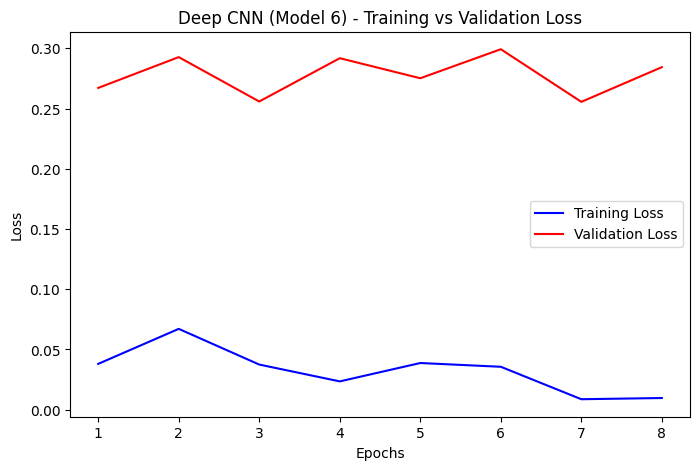

In [18]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model 6
plot_loss_curves(history6, model_name="Deep CNN (Model 6)")

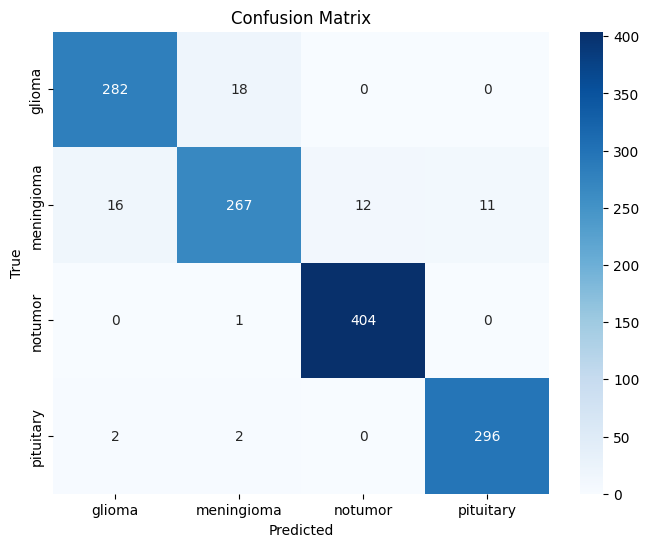


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       300
  meningioma       0.93      0.87      0.90       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [2]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model06_best.h5", test_ds, class_names)
